In [1]:
import pandas as pd
import numpy as np
from decimal import Decimal
from collections import namedtuple
import matplotlib.pyplot as plt

# 当該住戸の外皮の部位の面積等を用いずに外皮性能を評価する方法

本計算方法は、省エネ基準の「当該住戸の外皮の部位の面積等を用いずに外皮性能を評価する方法」に、以下のアレンジを加えた評価となっています。

- 省エネ基準では主開口部の方位は南西に固定されているところ、本計算方法では8方位の中から選択可能
- 省エネ基準では、窓のU値・η値(暖房期・冷房期）について1種類のみ指定可能であるところ、本計算方法では主開口とそのほかの開口に分けて入力可能
- 屋根／天井、外壁、床について省エネ基準でのU値入力はそのままに、R値と断熱材厚さからU値を計算できる手法を追加
- ドアについて省エネ基準でのU値入力はそのままに、枠の種類・戸の種類・ガラスの有無と有りの場合のUg値からU値を計算できる手法を追加
- 窓について省エネ基準でのU値入力はそのままに、建具の種類、Ug値からU値を計算できる手法を追加
- 土間床周辺部について省エネ基準でのψ値入力はそのままに、断熱材の厚さや長さ、施工位置などからψを計算する手法を追加

## デフォルトで設定された面積

In [2]:
direction      = namedtuple( 'direction',      ('ES0', 'ES90', 'ES180', 'ES270'       ) )
direction_base = namedtuple( 'direction_base', ('ES0', 'ES90', 'ES180', 'ES270', 'IS' ) )

In [3]:
class Area_and_Length:
    
    def __init__(self, house):
        # house には 'floor_ins' 又は 'base_ins' を指定する。
        
        if house == 'floor_ins':
            house_num = 0
        elif house == 'base_ins':
            house_num = 1
        else:
            raise("Wrong character for house type")

        # 外皮の部位の面積の合計(m2)
        self.env = [ 266.10, 275.69 ][house_num]

        # 延べ床面積の合計(m2)
        self.A = 90.0
        
        # 屋根又は天井の面積(m2)
        self.roof = 50.85
        
        # 壁の面積(m2)
        wall_0   = 30.47
        wall_90  = 22.37
        wall_180 = 47.92
        wall_270 = 22.28
        self.wall = direction( wall_0, wall_90, wall_180, wall_270 )
        
        # ドアの面積(m2)
        door_0   = 0.00
        door_90  = 1.89
        door_180 = 1.62
        door_270 = 0.00
        self.door = direction ( door_0, door_90, door_180, door_270 )
        
        # 窓の面積(m2)
        wnd_0   = 22.69
        wnd_90  =  2.38
        wnd_180 =  3.63
        wnd_270 =  4.37
        self.wnd = direction ( wnd_0, wnd_90, wnd_180, wnd_270 )

        # 床（床断熱した床）の面積(m2)
        self.floor = [ 45.05, 0.0 ][house_num]

        # 玄関等を除く基礎の面積(m2)
        base_0   = [ 0.00, 5.30 ][house_num]
        base_90  = [ 0.91, 1.48 ][house_num]
        base_180 = [ 0.91, 4.62 ][house_num]
        base_270 = [ 0.00, 2.40 ][house_num]
        base_IS  = [ 1.82, 0.00 ][house_num]
        self.base = direction_base ( base_0, base_90, base_180, base_270, base_IS )
        
        # 玄関等の基礎の面積(m2)
        base_d_0   = [ 0.00, 0.00 ][house_num]
        base_d_90  = [ 0.33, 0.33 ][house_num]
        base_d_180 = [ 0.25, 0.25 ][house_num]
        base_d_270 = [ 0.00, 0.00 ][house_num]
        base_d_IS  = [ 0.57, 0.00 ][house_num]
        self.base_d = direction_base ( base_d_0, base_d_90, base_d_180, base_d_270, base_d_IS )

        # 玄関等を除く土間床等の外周部の長さ(m)
        prm_0   = [ 0.00, 10.61 ][house_num] 
        prm_90  = [ 1.82,  2.97 ][house_num] 
        prm_180 = [ 1.82,  9.24 ][house_num] 
        prm_270 = [ 0.00,  4.79 ][house_num] 
        prm_IS  = [ 3.64,  0.00 ][house_num] 
        self.prm = direction_base ( prm_0, prm_90, prm_180, prm_270, prm_IS )
        
        # 玄関等の土間床等の外周部の長さ(m)
        prm_d_0   = [ 0.00, 0.00 ][house_num]
        prm_d_90  = [ 1.82, 1.82 ][house_num]
        prm_d_180 = [ 1.37, 1.37 ][house_num]
        prm_d_270 = [ 0.00, 0.00 ][house_num]
        prm_d_IS  = [ 3.19, 0.00 ][house_num]
        self.prm_d = direction_base ( prm_d_0, prm_d_90, prm_d_180, prm_d_270, prm_d_IS )

設定された値の確認

In [4]:
(Area_and_Length('floor_ins').env, Area_and_Length('base_ins').env )

(266.1, 275.69)

In [5]:
(Area_and_Length('floor_ins').A, Area_and_Length('base_ins').A )

(90.0, 90.0)

In [6]:
(Area_and_Length('floor_ins').roof, Area_and_Length('base_ins').roof )

(50.85, 50.85)

In [7]:
(Area_and_Length('floor_ins').wall, Area_and_Length('base_ins').wall )

(direction(ES0=30.47, ES90=22.37, ES180=47.92, ES270=22.28),
 direction(ES0=30.47, ES90=22.37, ES180=47.92, ES270=22.28))

In [8]:
(Area_and_Length('floor_ins').door, Area_and_Length('base_ins').door )

(direction(ES0=0.0, ES90=1.89, ES180=1.62, ES270=0.0),
 direction(ES0=0.0, ES90=1.89, ES180=1.62, ES270=0.0))

In [9]:
(Area_and_Length('floor_ins').wnd, Area_and_Length('base_ins').wnd )

(direction(ES0=22.69, ES90=2.38, ES180=3.63, ES270=4.37),
 direction(ES0=22.69, ES90=2.38, ES180=3.63, ES270=4.37))

In [10]:
(Area_and_Length('floor_ins').floor, Area_and_Length('base_ins').floor )

(45.05, 0.0)

In [11]:
(Area_and_Length('floor_ins').base, Area_and_Length('base_ins').base )

(direction_base(ES0=0.0, ES90=0.91, ES180=0.91, ES270=0.0, IS=1.82),
 direction_base(ES0=5.3, ES90=1.48, ES180=4.62, ES270=2.4, IS=0.0))

In [12]:
(Area_and_Length('floor_ins').base_d, Area_and_Length('base_ins').base_d)

(direction_base(ES0=0.0, ES90=0.33, ES180=0.25, ES270=0.0, IS=0.57),
 direction_base(ES0=0.0, ES90=0.33, ES180=0.25, ES270=0.0, IS=0.0))

In [13]:
(Area_and_Length('floor_ins').prm, Area_and_Length('base_ins').prm )

(direction_base(ES0=0.0, ES90=1.82, ES180=1.82, ES270=0.0, IS=3.64),
 direction_base(ES0=10.61, ES90=2.97, ES180=9.24, ES270=4.79, IS=0.0))

In [14]:
(Area_and_Length('floor_ins').prm_d, Area_and_Length('base_ins').prm_d )

(direction_base(ES0=0.0, ES90=1.82, ES180=1.37, ES270=0.0, IS=3.19),
 direction_base(ES0=0.0, ES90=1.82, ES180=1.37, ES270=0.0, IS=0.0))

## 方位係数

In [15]:
orientation_coeff = namedtuple( 'orientation_coeff', ('S', 'SW', 'W', 'NW', 'N', 'NE', 'E', 'SE', 'top', 'bottom' ) )

## 方位係数(暖房期)

In [16]:
class Nu_H:
    
    def __init__( self, region ):
        if region < 1:
            raise ( 'value error of region' )
        S      = [ 0.935, 0.856, 0.851, 0.815, 0.983, 0.936, 1.023, 'ND' ][region-1]
        SW     = [ 0.790, 0.753, 0.750, 0.723, 0.815, 0.763, 0.848, 'ND' ][region-1]
        W      = [ 0.535, 0.544, 0.542, 0.527, 0.538, 0.523, 0.548, 'ND' ][region-1]
        NW     = [ 0.325, 0.341, 0.351, 0.326, 0.297, 0.317, 0.284, 'ND' ][region-1]
        N      = [ 0.260, 0.263, 0.284, 0.256, 0.238, 0.261, 0.227, 'ND' ][region-1]
        NE     = [ 0.333, 0.341, 0.348, 0.330, 0.310, 0.325, 0.281, 'ND' ][region-1]
        E      = [ 0.564, 0.554, 0.540, 0.531, 0.568, 0.579, 0.543, 'ND' ][region-1]
        SE     = [ 0.823, 0.766, 0.751, 0.724, 0.846, 0.833, 0.843, 'ND' ][region-1]
        top    = [ 1.0,   1.0,   1.0,   1.0,   1.0,   1.0,   1.0,   'ND' ][region-1]
        bottom = [ 0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   'ND' ][region-1]
        self.value = orientation_coeff ( S, SW, W, NW, N, NE, E, SE, top, bottom )

In [17]:
Nu_H(1).value

orientation_coeff(S=0.935, SW=0.79, W=0.535, NW=0.325, N=0.26, NE=0.333, E=0.564, SE=0.823, top=1.0, bottom=0.0)

In [18]:
Nu_H(2).value

orientation_coeff(S=0.856, SW=0.753, W=0.544, NW=0.341, N=0.263, NE=0.341, E=0.554, SE=0.766, top=1.0, bottom=0.0)

In [19]:
Nu_H(3).value

orientation_coeff(S=0.851, SW=0.75, W=0.542, NW=0.351, N=0.284, NE=0.348, E=0.54, SE=0.751, top=1.0, bottom=0.0)

In [20]:
Nu_H(4).value

orientation_coeff(S=0.815, SW=0.723, W=0.527, NW=0.326, N=0.256, NE=0.33, E=0.531, SE=0.724, top=1.0, bottom=0.0)

In [21]:
Nu_H(5).value

orientation_coeff(S=0.983, SW=0.815, W=0.538, NW=0.297, N=0.238, NE=0.31, E=0.568, SE=0.846, top=1.0, bottom=0.0)

In [22]:
Nu_H(6).value

orientation_coeff(S=0.936, SW=0.763, W=0.523, NW=0.317, N=0.261, NE=0.325, E=0.579, SE=0.833, top=1.0, bottom=0.0)

In [23]:
Nu_H(7).value

orientation_coeff(S=1.023, SW=0.848, W=0.548, NW=0.284, N=0.227, NE=0.281, E=0.543, SE=0.843, top=1.0, bottom=0.0)

In [24]:
Nu_H(8).value

orientation_coeff(S='ND', SW='ND', W='ND', NW='ND', N='ND', NE='ND', E='ND', SE='ND', top='ND', bottom='ND')

## 方位係数(冷房期)

In [25]:
class Nu_C:
    
    def __init__( self, region ):
        if region < 1:
            raise ( 'value error of region' )
        S      = [ 0.502, 0.507, 0.476, 0.437, 0.472, 0.434, 0.412, 0.480 ][region-1]
        SW     = [ 0.526, 0.548, 0.550, 0.481, 0.520, 0.491, 0.479, 0.517 ][region-1]
        W      = [ 0.508, 0.529, 0.553, 0.481, 0.518, 0.504, 0.495, 0.505 ][region-1]
        NW     = [ 0.411, 0.428, 0.447, 0.401, 0.442, 0.427, 0.406, 0.411 ][region-1]
        N      = [ 0.329, 0.341, 0.335, 0.322, 0.373, 0.341, 0.307, 0.325 ][region-1]
        NE     = [ 0.430, 0.412, 0.390, 0.426, 0.437, 0.431, 0.415, 0.414 ][region-1]
        E      = [ 0.545, 0.503, 0.468, 0.518, 0.500, 0.512, 0.509, 0.515 ][region-1]
        SE     = [ 0.560, 0.527, 0.487, 0.508, 0.500, 0.498, 0.490, 0.528 ][region-1]
        top    = [ 1.0,   1.0,   1.0,   1.0,   1.0,   1.0,   1.0,   1.0   ][region-1]
        bottom = [ 0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0   ][region-1]
        self.value = orientation_coeff ( S, SW, W, NW, N, NE, E, SE, top, bottom )

In [26]:
Nu_C(1).value

orientation_coeff(S=0.502, SW=0.526, W=0.508, NW=0.411, N=0.329, NE=0.43, E=0.545, SE=0.56, top=1.0, bottom=0.0)

In [27]:
Nu_C(2).value

orientation_coeff(S=0.507, SW=0.548, W=0.529, NW=0.428, N=0.341, NE=0.412, E=0.503, SE=0.527, top=1.0, bottom=0.0)

In [28]:
Nu_C(3).value

orientation_coeff(S=0.476, SW=0.55, W=0.553, NW=0.447, N=0.335, NE=0.39, E=0.468, SE=0.487, top=1.0, bottom=0.0)

In [29]:
Nu_C(4).value

orientation_coeff(S=0.437, SW=0.481, W=0.481, NW=0.401, N=0.322, NE=0.426, E=0.518, SE=0.508, top=1.0, bottom=0.0)

In [30]:
Nu_C(5).value

orientation_coeff(S=0.472, SW=0.52, W=0.518, NW=0.442, N=0.373, NE=0.437, E=0.5, SE=0.5, top=1.0, bottom=0.0)

In [31]:
Nu_C(6).value

orientation_coeff(S=0.434, SW=0.491, W=0.504, NW=0.427, N=0.341, NE=0.431, E=0.512, SE=0.498, top=1.0, bottom=0.0)

In [32]:
Nu_C(7).value

orientation_coeff(S=0.412, SW=0.479, W=0.495, NW=0.406, N=0.307, NE=0.415, E=0.509, SE=0.49, top=1.0, bottom=0.0)

In [33]:
Nu_C(8).value

orientation_coeff(S=0.48, SW=0.517, W=0.505, NW=0.411, N=0.325, NE=0.414, E=0.515, SE=0.528, top=1.0, bottom=0.0)

## 取得日射熱補正係数(デフォルト値)

In [34]:
class f_H_default:
    
    def __init__( self ):
        
        self.S      = [ 0.655333333, 0.628666667, 0.637333333, 0.616,       0.654333333, 0.642,       0.649666667, 'ND' ]
        self.SW     = [ 0.658,       0.647666667, 0.649666667, 0.642333333, 0.666666667, 0.653666667, 0.669666667, 'ND' ]
        self.W      = [ 0.636666667, 0.643333333, 0.636333333, 0.636,       0.642666667, 0.640666667, 0.643,       'ND' ]
        self.NW     = [ 0.605,       0.604,       0.601666667, 0.595,       0.595,       0.595,       0.589333333, 'ND' ]
        self.N      = [ 0.62,        0.618,       0.617666667, 0.619666667, 0.628,       0.627666667, 0.636,       'ND' ]
        self.NE     = [ 0.602,       0.605,       0.601666667, 0.597666667, 0.592,       0.589,       0.587333333, 'ND' ]
        self.E      = [ 0.640333333, 0.642333333, 0.631333333, 0.637333333, 0.646666667, 0.642333333, 0.639666667, 'ND' ]
        self.SE     = [ 0.664666667, 0.655666667, 0.648666667, 0.642333333, 0.670666667, 0.674666667, 0.665666667, 'ND' ]
        self.top    = [ 'ND',        'ND',        'ND',        'ND',        'ND',        'ND',        'ND',        'ND' ]
        self.bottom = [ 'ND',        'ND',        'ND',        'ND',        'ND',        'ND',        'ND',        'ND' ]

    def get_value( self, region ):
        # region: 地域の区分 ( 1 ～ 8 )
        if region < 1:
            raise ( 'value error of region' )
        
        idx = region - 1
        
        return orientation_coeff ( self.S[idx], self.SW[idx], self.W[idx], self.NW[idx],
                                   self.N[idx], self.NE[idx], self.E[idx], self.SE[idx], self.top[idx], self.bottom[idx] )

In [35]:
f_H_default().get_value( region = 1 )

orientation_coeff(S=0.655333333, SW=0.658, W=0.636666667, NW=0.605, N=0.62, NE=0.602, E=0.640333333, SE=0.664666667, top='ND', bottom='ND')

In [36]:
f_H_default().get_value( region = 2 )

orientation_coeff(S=0.628666667, SW=0.647666667, W=0.643333333, NW=0.604, N=0.618, NE=0.605, E=0.642333333, SE=0.655666667, top='ND', bottom='ND')

In [37]:
f_H_default().get_value( region = 3 )

orientation_coeff(S=0.637333333, SW=0.649666667, W=0.636333333, NW=0.601666667, N=0.617666667, NE=0.601666667, E=0.631333333, SE=0.648666667, top='ND', bottom='ND')

In [38]:
f_H_default().get_value( region = 4 )

orientation_coeff(S=0.616, SW=0.642333333, W=0.636, NW=0.595, N=0.619666667, NE=0.597666667, E=0.637333333, SE=0.642333333, top='ND', bottom='ND')

In [39]:
f_H_default().get_value( region = 5 )

orientation_coeff(S=0.654333333, SW=0.666666667, W=0.642666667, NW=0.595, N=0.628, NE=0.592, E=0.646666667, SE=0.670666667, top='ND', bottom='ND')

In [40]:
f_H_default().get_value( region = 6 )

orientation_coeff(S=0.642, SW=0.653666667, W=0.640666667, NW=0.595, N=0.627666667, NE=0.589, E=0.642333333, SE=0.674666667, top='ND', bottom='ND')

In [41]:
f_H_default().get_value( region = 7 )

orientation_coeff(S=0.649666667, SW=0.669666667, W=0.643, NW=0.589333333, N=0.636, NE=0.587333333, E=0.639666667, SE=0.665666667, top='ND', bottom='ND')

In [42]:
f_H_default().get_value( region = 8 )

orientation_coeff(S='ND', SW='ND', W='ND', NW='ND', N='ND', NE='ND', E='ND', SE='ND', top='ND', bottom='ND')

In [43]:
class f_C_default:
    
    def __init__( self ):
            
        self.S_n      = [ 0.807, 0.812, 0.799, 0.784, 0.807, 0.795, 0.788, 0.824 ]
        self.SW_n     = [ 0.86,  0.861, 0.859, 0.85,  0.858, 0.852, 0.847, 0.858 ]
        self.W_n      = [ 0.88,  0.878, 0.883, 0.876, 0.875, 0.88,  0.88,  0.876 ]
        self.NW_n     = [ 0.866, 0.864, 0.865, 0.861, 0.862, 0.864, 0.862, 0.859 ]
        self.N_n      = [ 0.853, 0.857, 0.853, 0.852, 0.86,  0.847, 0.838, 0.848 ]
        self.NE_n     = [ 0.865, 0.864, 0.862, 0.861, 0.863, 0.862, 0.861, 0.857 ]
        self.E_n      = [ 0.882, 0.877, 0.87,  0.881, 0.874, 0.88,  0.881, 0.877 ]
        self.SE_n     = [ 0.864, 0.858, 0.853, 0.853, 0.854, 0.852, 0.849, 0.86  ]
        self.top_n    = [ 'ND',  'ND',  'ND',  'ND',  'ND',  'ND',  'ND',  'ND'  ]
        self.bottom_n = [ 'ND',  'ND',  'ND',  'ND',  'ND',  'ND',  'ND',  'ND'  ]
        
        self.S_y      = [ 0.685,       0.688,       0.685,       0.683,       0.687666667, 0.677666667, 0.672333333, 0.678       ]
        self.SW_y     = [ 0.689,       0.684666667, 0.682333333, 0.677,       0.682,       0.678333333, 0.678666667, 0.673       ]
        self.W_y      = [ 0.700666667, 0.691666667, 0.679666667, 0.690666667, 0.685,       0.689666667, 0.692,       0.691666667 ]
        self.NW_y     = [ 0.65,        0.644333333, 0.634,       0.632666667, 0.642333333, 0.636333333, 0.631,       0.654666667 ]
        self.N_y      = [ 0.545,       0.553333333, 0.538,       0.525,       0.565,       0.562333333, 0.558,       0.609333333 ]
        self.NE_y     = [ 0.646,       0.646666667, 0.644333333, 0.631,       0.647666667, 0.637333333, 0.628333333, 0.651666667 ]
        self.E_y      = [ 0.698,       0.692333333, 0.699666667, 0.683666667, 0.686333333, 0.691666667, 0.690666667, 0.691666667 ]
        self.SE_y     = [ 0.689,       0.685666667, 0.686666667, 0.677333333, 0.678666667, 0.683333333, 0.679333333, 0.677333333 ]
        self.top_y    = [ 'ND',        'ND',        'ND',        'ND',        'ND',        'ND',        'ND',        'ND'        ]
        self.bottom_y = [ 'ND',        'ND',        'ND',        'ND',        'ND',        'ND',        'ND',        'ND'        ]

    def get_value( self, region, effective_eaves ):

        # region: 地域の区分 ( 1 ～ 8 )
        # effective_eaves: 有効な日除けの有無 ( 'yes':あり, 'no':なし )
        
        if region < 1:
            raise ( 'value error of region' )
        
        idx = region - 1
        
        if ( effective_eaves == 'yes' ):
            return orientation_coeff ( self.S_y[idx], self.SW_y[idx], self.W_y[idx], self.NW_y[idx],
                                       self.N_y[idx], self.NE_y[idx], self.E_y[idx], self.SE_y[idx], self.top_y[idx], self.bottom_y[idx] )
        elif ( effective_eaves == 'no' ):
            return orientation_coeff ( self.S_n[idx], self.SW_n[idx], self.W_n[idx], self.NW_n[idx],
                                       self.N_n[idx], self.NE_n[idx], self.E_n[idx], self.SE_n[idx], self.top_n[idx], self.bottom_n[idx] )
        else:
            raise( 'wrong value of effective_eaves' )

In [44]:
f_C_default().get_value( region = 1, effective_eaves = 'yes' )

orientation_coeff(S=0.685, SW=0.689, W=0.700666667, NW=0.65, N=0.545, NE=0.646, E=0.698, SE=0.689, top='ND', bottom='ND')

In [45]:
f_C_default().get_value( region = 2, effective_eaves = 'yes' )

orientation_coeff(S=0.688, SW=0.684666667, W=0.691666667, NW=0.644333333, N=0.553333333, NE=0.646666667, E=0.692333333, SE=0.685666667, top='ND', bottom='ND')

In [46]:
f_C_default().get_value( region = 3, effective_eaves = 'yes' )

orientation_coeff(S=0.685, SW=0.682333333, W=0.679666667, NW=0.634, N=0.538, NE=0.644333333, E=0.699666667, SE=0.686666667, top='ND', bottom='ND')

In [47]:
f_C_default().get_value( region = 4, effective_eaves = 'yes' )

orientation_coeff(S=0.683, SW=0.677, W=0.690666667, NW=0.632666667, N=0.525, NE=0.631, E=0.683666667, SE=0.677333333, top='ND', bottom='ND')

In [48]:
f_C_default().get_value( region = 5, effective_eaves = 'yes' )

orientation_coeff(S=0.687666667, SW=0.682, W=0.685, NW=0.642333333, N=0.565, NE=0.647666667, E=0.686333333, SE=0.678666667, top='ND', bottom='ND')

In [49]:
f_C_default().get_value( region = 6, effective_eaves = 'yes' )

orientation_coeff(S=0.677666667, SW=0.678333333, W=0.689666667, NW=0.636333333, N=0.562333333, NE=0.637333333, E=0.691666667, SE=0.683333333, top='ND', bottom='ND')

In [50]:
f_C_default().get_value( region = 7, effective_eaves = 'yes' )

orientation_coeff(S=0.672333333, SW=0.678666667, W=0.692, NW=0.631, N=0.558, NE=0.628333333, E=0.690666667, SE=0.679333333, top='ND', bottom='ND')

In [51]:
f_C_default().get_value( region = 8, effective_eaves = 'yes' )

orientation_coeff(S=0.678, SW=0.673, W=0.691666667, NW=0.654666667, N=0.609333333, NE=0.651666667, E=0.691666667, SE=0.677333333, top='ND', bottom='ND')

In [52]:
f_C_default().get_value( region = 1, effective_eaves = 'no' )

orientation_coeff(S=0.807, SW=0.86, W=0.88, NW=0.866, N=0.853, NE=0.865, E=0.882, SE=0.864, top='ND', bottom='ND')

In [53]:
f_C_default().get_value( region = 2, effective_eaves = 'no' )

orientation_coeff(S=0.812, SW=0.861, W=0.878, NW=0.864, N=0.857, NE=0.864, E=0.877, SE=0.858, top='ND', bottom='ND')

In [54]:
f_C_default().get_value( region = 3, effective_eaves = 'no' )

orientation_coeff(S=0.799, SW=0.859, W=0.883, NW=0.865, N=0.853, NE=0.862, E=0.87, SE=0.853, top='ND', bottom='ND')

In [55]:
f_C_default().get_value( region = 4, effective_eaves = 'no' )

orientation_coeff(S=0.784, SW=0.85, W=0.876, NW=0.861, N=0.852, NE=0.861, E=0.881, SE=0.853, top='ND', bottom='ND')

In [56]:
f_C_default().get_value( region = 5, effective_eaves = 'no' )

orientation_coeff(S=0.807, SW=0.858, W=0.875, NW=0.862, N=0.86, NE=0.863, E=0.874, SE=0.854, top='ND', bottom='ND')

In [57]:
f_C_default().get_value( region = 6, effective_eaves = 'no' )

orientation_coeff(S=0.795, SW=0.852, W=0.88, NW=0.864, N=0.847, NE=0.862, E=0.88, SE=0.852, top='ND', bottom='ND')

In [58]:
f_C_default().get_value( region = 7, effective_eaves = 'no' )

orientation_coeff(S=0.788, SW=0.847, W=0.88, NW=0.862, N=0.838, NE=0.861, E=0.881, SE=0.849, top='ND', bottom='ND')

In [59]:
f_C_default().get_value( region = 8, effective_eaves = 'no' )

orientation_coeff(S=0.824, SW=0.858, W=0.876, NW=0.859, N=0.848, NE=0.857, E=0.877, SE=0.86, top='ND', bottom='ND')

## 外皮平均熱貫流率

外皮平均熱貫流率  
ここで計算した外皮平均熱貫流率$U_A$は少数点第2位未満を切り上げすることになっている。

$$ U_A= \frac{q}{A_{env}} $$

$U_A$:外皮平均熱貫流率(W/m<sup>2</sup>K)  
$q$:単位温度差あたりの外皮熱損失量(W/K)

In [60]:
def U_A(q,A_env):
    U_A_Raw = Decimal(q/A_env)
    # 小数点第3位未満を切り上げ
    return U_A_Raw.quantize(Decimal('0.00'), rounding = 'ROUND_UP')

## 暖房期の平均日射熱取得率

暖房期の平均日射熱取得率  
ここで計算した暖房期の平均日射熱取得率$\eta_{A,H}$は小数点第1位未満を切り下げすることになっている。

$$ \eta_{A,H}=\frac{m_H}{A_{env}}\times 100 $$

$\eta_{A,H}$:暖房期の平均日射熱取得率  
$m_H$:単位日射強度当たりの暖房期の日射熱取得量(W/(W/m<sup>2</sup>))

In [61]:
def eta_A_H(m_H,A_env):
    eta_A_H_Raw = Decimal(m_H/A_env*100)
    return eta_A_H_Raw.quantize(Decimal('0.0'), rounding = 'ROUND_DOWN')

## 冷房期の平均日射熱取得率

冷房期の平均日射熱取得率  
ここで計算した冷房期の平均日射熱取得率$\eta_{A,C}$は小数点第1位未満を切り上げすることになっている。

$$ \eta_{A,C}=\frac{m_C}{A_{env}}\times 100 $$

$\eta_{A,C}$:冷房期の平均日射熱取得率  
$m_C$:単位日射強度当たりの冷房期の日射熱取得量(W/(W/m<sup>2</sup>))

In [62]:
def eta_A_C(m_C,A_env):
    eta_A_C_Raw = Decimal(m_C/A_env*100)
    return eta_A_C_Raw.quantize(Decimal('0.0'), rounding = 'ROUND_UP')

## 単位温度差あたりの外皮熱損失量

単位温度差あたりの外皮熱損失量

$\begin{align} q &= q_{roof} + q_{wall} + q_{door} + q_{wnd} + q_{floor} + q_{base} + q_{base,d} + q_{prm} + q_{prm,d} \end{align}$ 

$q$:単位温度差当たりの外皮熱損失量(W/K)  

roof:屋根, wall:壁, door:ドア, wnd:窓, IF:断熱床, floor:床, base:基礎, d:玄関部分  

以下、各項目ごとに計算式を定義する。

$A$:面積(m<sup>2</sup>)  
$L$:長さ(m)  
$H$:温度差係数  
$U$:熱貫流率(W/m<sup>2</sup>K)  
$\psi$:線熱貫流率(W/mK)  

0,90,180,270: 主開口方位から時計回りに、順に、0度、90度、180度、270度  
OS,IS: 順に、室外側、室内側  

### 屋根

$\begin{align} q_{roof} = A_{roof} \times H_{roof} \times U_{roof} \end{align}$ 

In [63]:
def q_roof( A_roof, U_roof ):
    # 温度差係数は1.0
    H_roof = 1.0
    return A_roof * H_roof * U_roof

### 外壁

$\begin{align} q_{wall} = ( A_{wall,0} + A_{wall,90} + A_{wall,180} + A_{wall,270} ) \times H_{wall} \times U_{wall} \end{align}$ 

In [64]:
def q_wall( A_wall, U_wall ):
    # 温度差係数は1.0
    H_wall = 1.0
    return ( A_wall.ES0 + A_wall.ES90 + A_wall.ES180 + A_wall.ES270 ) * H_wall * U_wall

### ドア

$\begin{align} q_{door} = ( A_{door,0} + A_{door,90} + A_{door,180} + A_{door,270} ) \times H_{door} \times U_{door} \end{align}$ 

In [65]:
def q_door( A_door, U_door ):
    # 温度差係数は1.0
    H_door = 1.0
    return ( A_door.ES0 + A_door.ES90 + A_door.ES180 + A_door.ES270 ) * H_door * U_door

### 窓

$\begin{align} q_{wnd} = ( A_{wnd, 0} + A_{wnd, 90} + A_{wnd, 180} + A_{wnd, 270} ) \times H_{wnd}  \times U_{wnd} \end{align}$ 

In [66]:
def q_wnd( A_wnd, U_wnd_main, U_wnd_other ):
    # 温度差係数は1.0
    H_wnd = 1.0
    return ( A_wnd.ES0 * U_wnd_main + ( A_wnd.ES90 + A_wnd.ES180 + A_wnd.ES270 ) * U_wnd_other ) * H_wnd

### 床

$\begin{align} q_{floor} = A_{IF} \times H_{floor} \times U_{floor} \end{align}$ 

In [67]:
def q_floor( A_IF, U_floor ):
    # 温度差係数は0.7
    H_floor = 0.7
    return A_IF * H_floor * U_floor

### 基礎

$\begin{align} q_{base} = ( ( A_{base,0} + A_{base,90} + A_{base,180} + A_{base,270} ) \times H_{base,OS} + A_{base,IS} \times H_{base,IS} ) \times U_{base} \end{align}$

In [68]:
def q_base( A_base, U_base ):
    # 温度差係数(室外側)は1.0
    # 温度差係数(室内側)は0.7
    H_base_OS = 1.0
    H_base_IS = 0.7
    q_base_OS  = ( A_base.ES0 + A_base.ES90 + A_base.ES180 + A_base.ES270 ) * H_base_OS * U_base
    q_base_IS  =   A_base.IS                                                * H_base_IS * U_base
    return q_base_OS + q_base_IS

### 基礎(玄関ドア等)

$\begin{align} q_{base,d} = ( ( A_{base,d,0} + A_{base,d,90} + A_{base,d,180} + A_{base,d,270} ) \times H_{base,OS} + A_{base,d,IS} \times H_{base,IS} ) \times U_{base,d} \end{align}$

In [69]:
def q_base_d( A_base_d, U_base_d ):
    # 温度差係数(室外側)は1.0
    # 温度差係数(室内側)は0.7
    H_base_OS = 1.0
    H_base_IS = 0.7
    q_base_d_OS = ( A_base_d.ES0 + A_base_d.ES90 + A_base_d.ES180 + A_base_d.ES270 ) * H_base_OS * U_base_d
    q_base_d_IS =   A_base_d.IS                                                      * H_base_IS * U_base_d
    return q_base_d_OS + q_base_d_IS

### 土間床周辺部

$\begin{align} q_{prm} = ( ( L_{prm,  0} + L_{prm,  90} + L_{prm,  180} + L_{prm,  270} ) \times H_{prm,OS} + L_{prm,IS}   \times H_{prm,IS} ) \times \psi_{prm} \end{align}$ 

In [70]:
def q_prm( L_prm, psi_prm ):
    # 温度差係数(室外側)は1.0
    # 温度差係数(室内側)は0.7
    H_prm_OS = 1.0
    H_prm_IS = 0.7
    q_prm_OS = ( L_prm.ES0 + L_prm.ES90 + L_prm.ES180 + L_prm.ES270 ) * H_prm_OS * psi_prm
    q_prm_IS =   L_prm.IS                                             * H_prm_IS * psi_prm
    return q_prm_OS + q_prm_IS

### 土間床周辺部(玄関ドア等)

$\begin{align} q_{prm,d} = ( ( L_{prm,d,0} + L_{prm,d,90} + L_{prm,d,180} + L_{prm,d,270} ) \times H_{prm,OS} + L_{prm,d,IS} \times H_{prm,IS} ) \times \psi_{prm,d} \end{align}$ 

In [71]:
def q_prm_d( L_prm_d, psi_prm_d ):
    # 温度差係数(室外側)は1.0
    # 温度差係数(室内側)は0.7
    H_prm_OS = 1.0
    H_prm_IS = 0.7
    q_prm_d_OS  = ( L_prm_d.ES0 + L_prm_d.ES90 + L_prm_d.ES180 + L_prm_d.ES270 ) * H_prm_OS * psi_prm_d
    q_prm_d_IS  =   L_prm_d.IS                                                   * H_prm_IS * psi_prm_d
    return q_prm_d_OS + q_prm_d_IS

面積はデフォルト値をおく。
温度差係数はデフォルト値を使用した。
床断熱(floor_ins)・基礎断熱(floor_base)のどちらにも当てはまらない場合（床断熱と基礎断熱の併用など）は、両方の値を計算し、大きい方の値を採用する。

In [72]:
def U_A_simple_unit(house, U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, U_base, U_base_d, psi_prm, psi_prm_d):
    
    # デフォルト面積の読み込み
    area = Area_and_Length(house)
    
    q_all = q_roof   ( area.roof,   U_roof   ) \
          + q_wall   ( area.wall,   U_wall   ) \
          + q_door   ( area.door,   U_door   ) \
          + q_wnd    ( area.wnd,    U_wnd_main, U_wnd_other ) \
          + q_floor  ( area.floor,  U_floor  ) \
          + q_base   ( area.base,   U_base   ) \
          + q_base_d ( area.base_d, U_base_d ) \
          + q_prm    ( area.prm,    psi_prm  ) \
          + q_prm_d  ( area.prm_d,  psi_prm_d)
    return U_A(q_all, area.env)

In [73]:
def AppliedHouseDecision(house, U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, U_base, U_base_d, psi_prm, psi_prm_d):
    if ( house == 'floor_ins' ) | ( house == 'base_ins' ) :
        return house
    else:
        f_i = U_A_simple_unit('floor_ins', U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, U_base, U_base_d, psi_prm, psi_prm_d)
        f_b = U_A_simple_unit('base_ins',  U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, U_base, U_base_d, psi_prm, psi_prm_d)
        if f_i > f_b:
            return 'floor_ins'
        else:
            return 'base_ins'

In [74]:
def U_A_simple(house, U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, U_base, U_base_d, psi_prm, psi_prm_d):
    
    # 床断熱住宅と基礎断熱住宅の併用住宅の場合、それぞれ計算してU値で大きい方を採用する。その判断。
    house_d = AppliedHouseDecision(house, U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, U_base, U_base_d, psi_prm, psi_prm_d)
    
    return U_A_simple_unit(house_d, U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, U_base, U_base_d, psi_prm, psi_prm_d)

単位日射強度当たりの日射熱取得量(暖房期)  

$ \begin{align}m_H &= m_{H,roof} + m_{H,wall} + m_{H,door} + m_{H,wnd} + m_{H,base} + m_{H,base,d} \end{align}$  

単位日射強度当たりの日射熱取得量(冷房期)  

$ \begin{align}m_C &= m_{C,roof} + m_{C,wall} + m_{C,door} + m_{C,wnd} + m_{C,base} + m_{C,base,d} \end{align}$  

$m$:単位日射強度当たりの日射熱取得量(W/(W/m<sup>2</sup>))  

H:暖房期, C:冷房期  

roof:屋根, wall:壁, door:ドア, wnd:窓, base:基礎, d:玄関部分

以下、各項目ごとに計算式を定義する。

$A$:面積(m<sup>2</sup>)  
$\nu$:方位係数  
$\eta$:日射熱取得率  

0,90,180,270: 主開口方位から時計回りに、順に、0度、90度、180度、270度  
top,bottom: 順に、上面、下面  

### 屋根

$ \begin{align} m_{H,roof} = A_{roof} \times \nu_{H,top} \times \eta_{H,roof} \end{align}$  
$ \begin{align} m_{C,roof} = A_{roof} \times \nu_{C,top} \times \eta_{C,roof} \end{align}$  

In [75]:
def m_H_roof( A_roof, nu_H_top, eta_H_roof ):
    return A_roof * nu_H_top * eta_H_roof

def m_C_roof( A_roof, nu_C_top, eta_C_roof ):
    return A_roof * nu_C_top * eta_C_roof

### 壁

$ \begin{align} m_{H,wall} = ( A_{wall,0} \times \nu_{H,0} + A_{wall,90} \times \nu_{H,90} + A_{wall,180} \times \nu_{H,180} + A_{wall,270} \times \nu_{H,270} ) \times \eta_{H,wall} \end{align} $  
$ \begin{align} m_{C,wall} = ( A_{wall,0} \times \nu_{C,0} + A_{wall,90} \times \nu_{C,90} + A_{wall,180} \times \nu_{C,180} + A_{wall,270} \times \nu_{C,270} ) \times \eta_{C,wall} \end{align} $  

In [76]:
def m_H_wall( A_wall, nu_H, eta_H_wall ):
    return A_wall.ES0   * nu_H.ES0   * eta_H_wall \
         + A_wall.ES90  * nu_H.ES90  * eta_H_wall \
         + A_wall.ES180 * nu_H.ES180 * eta_H_wall \
         + A_wall.ES270 * nu_H.ES270 * eta_H_wall

def m_C_wall( A_wall, nu_C, eta_C_wall ):
    return A_wall.ES0   * nu_C.ES0   * eta_C_wall \
         + A_wall.ES90  * nu_C.ES90  * eta_C_wall \
         + A_wall.ES180 * nu_C.ES180 * eta_C_wall \
         + A_wall.ES270 * nu_C.ES270 * eta_C_wall


### ドア

$ \begin{align} m_{H,door} = ( A_{door,0} \times \nu_{H,0} + A_{door,90} \times \nu_{H,90} + A_{door,180} \times \nu_{H,180} + A_{door,270} \times \nu_{H,270} ) \times \eta_{H,door} \end{align} $  
$ \begin{align} m_{C,door} = ( A_{door,0} \times \nu_{C,0} + A_{door,90} \times \nu_{C,90} + A_{door,180} \times \nu_{C,180} + A_{door,270} \times \nu_{C,270} ) \times \eta_{C,door} \end{align} $  

In [77]:
def m_H_door( A_door, nu_H, eta_H_door ):
    return A_door.ES0   * nu_H.ES0   * eta_H_door \
         + A_door.ES90  * nu_H.ES90  * eta_H_door \
         + A_door.ES180 * nu_H.ES180 * eta_H_door \
         + A_door.ES270 * nu_H.ES270 * eta_H_door

def m_C_door( A_door, nu_C, eta_C_door ):
    return A_door.ES0   * nu_C.ES0   * eta_C_door \
         + A_door.ES90  * nu_C.ES90  * eta_C_door \
         + A_door.ES180 * nu_C.ES180 * eta_C_door \
         + A_door.ES270 * nu_C.ES270 * eta_C_door

### 窓

窓の場合は、日除け等を勘案した取得日射量補正係数が方位によって異なること、主開口とその他の物性を分けて入力できること等から、方位別に$\eta$値を設定する。  
$ \begin{align} m_{H,wnd} = A_{wnd,0} \times \nu_{H,0} \times \eta_{H,wnd,0} + A_{wnd,90} \times \nu_{H,90} \times \eta_{H,wnd,90} + A_{wnd,180} \times \nu_{H,180} \times \eta_{H,wnd,180} + A_{wnd,270} \times \nu_{H,270} \times \eta_{H,wnd,270} \end{align} $  
$ \begin{align} m_{C,wnd} = A_{wnd,0} \times \nu_{C,0} \times \eta_{C,wnd,0} + A_{wnd,90} \times \nu_{C,90} \times \eta_{C,wnd,90} + A_{wnd,180} \times \nu_{C,180} \times \eta_{C,wnd,180} + A_{wnd,270} \times \nu_{C,270} \times \eta_{C,wnd,270} \end{align} $  

In [78]:
def m_H_wnd( A_wnd, nu_H, eta_H_wnd):
    return A_wnd.ES0   * nu_H.ES0   * eta_H_wnd.ES0 \
         + A_wnd.ES90  * nu_H.ES90  * eta_H_wnd.ES90 \
         + A_wnd.ES180 * nu_H.ES180 * eta_H_wnd.ES180 \
         + A_wnd.ES270 * nu_H.ES270 * eta_H_wnd.ES270

def m_C_wnd( A_wnd, nu_C, eta_C_wnd):
    return A_wnd.ES0   * nu_C.ES0   * eta_C_wnd.ES0 \
         + A_wnd.ES90  * nu_C.ES90  * eta_C_wnd.ES90 \
         + A_wnd.ES180 * nu_C.ES180 * eta_C_wnd.ES180 \
         + A_wnd.ES270 * nu_C.ES270 * eta_C_wnd.ES270

### 基礎

$ \begin{align} m_{H,base} = ( A_{base,0} \times \nu_{H,0} + A_{base,90} \times \nu_{H,90} + A_{base,180} \times \nu_{H,180} + A_{base,270} \times \nu_{H,270} ) \times \eta_{H,base} \end{align} $  
$ \begin{align} m_{C,base} = ( A_{base,0} \times \nu_{C,0} + A_{base,90} \times \nu_{C,90} + A_{base,180} \times \nu_{C,180} + A_{base,270} \times \nu_{C,270} ) \times \eta_{C,base} \end{align} $  

In [79]:
def m_H_base( A_base, nu_H, eta_H_base ):
    return A_base.ES0   * nu_H.ES0   * eta_H_base \
         + A_base.ES90  * nu_H.ES90  * eta_H_base \
         + A_base.ES180 * nu_H.ES180 * eta_H_base \
         + A_base.ES270 * nu_H.ES270 * eta_H_base
    
def m_C_base( A_base, nu_C, eta_C_base ):
    return A_base.ES0   * nu_C.ES0   * eta_C_base \
         + A_base.ES90  * nu_C.ES90  * eta_C_base \
         + A_base.ES180 * nu_C.ES180 * eta_C_base \
         + A_base.ES270 * nu_C.ES270 * eta_C_base

### 基礎(玄関ドア等)

$ \begin{align} m_{H,base,d} = ( A_{base,d,0} \times \nu_{H,0} + A_{base,d,90} \times \nu_{H,90} + A_{base,d,180} \times \nu_{H,180} + A_{base,d,270} \times \nu_{H,270} ) \times \eta_{H,base,d} \end{align} $  
$ \begin{align} m_{C,base,d} = ( A_{base,d,0} \times \nu_{C,0} + A_{base,d,90} \times \nu_{C,90} + A_{base,d,180} \times \nu_{C,180} + A_{base,d,270} \times \nu_{C,270} ) \times \eta_{C,base,d} \end{align} $  

In [80]:
def m_H_base_d( A_base_d, nu_H, eta_H_base_d ):
    return A_base_d.ES0   * nu_H.ES0   * eta_H_base_d \
         + A_base_d.ES90  * nu_H.ES90  * eta_H_base_d \
         + A_base_d.ES180 * nu_H.ES180 * eta_H_base_d \
         + A_base_d.ES270 * nu_H.ES270 * eta_H_base_d
    
def m_C_base_d( A_base_d, nu_C, eta_C_base_d ):
    return A_base_d.ES0   * nu_C.ES0   * eta_C_base_d \
         + A_base_d.ES90  * nu_C.ES90  * eta_C_base_d \
         + A_base_d.ES180 * nu_C.ES180 * eta_C_base_d \
         + A_base_d.ES270 * nu_C.ES270 * eta_C_base_d

In [81]:
m_H_roof( Area_and_Length('floor_ins').roof, Nu_H(6).value.top, 1.0 )

50.85

In [82]:
nu_H = direction ( Nu_H(6).value.SW, Nu_H(6).value.NW, Nu_H(6).value.NE, Nu_H(6).value.SE )
m_H_wall( Area_and_Length('floor_ins').wall, nu_H, 1.0)

64.47314

In [83]:
nu_H = direction ( Nu_H(6).value.SW, Nu_H(6).value.NW, Nu_H(6).value.NE, Nu_H(6).value.SE )
eta_H = direction ( 1.0, 1.0, 1.0, 1.0 )
m_H_wnd( Area_and_Length('floor_ins').wnd, nu_H, eta_H)

22.88689

In [84]:
def nu_from_main_direction( OC, main_direction ):
    # OC orientation_coeff 型
    # main_direction: 主たる方位　( 'S', 'SW', 'W', 'NW', 'N', 'NE', 'E', 'SE' )
    # direction 型: 主たる方位から、0,90,180,270 度の値
    if   ( main_direction == 'S' ): return direction ( OC.value.S,  OC.value.W,  OC.value.N,  OC.value.E  )
    elif ( main_direction == 'SW'): return direction ( OC.value.SW, OC.value.NW, OC.value.NE, OC.value.SE )
    elif ( main_direction == 'W' ): return direction ( OC.value.W,  OC.value.N,  OC.value.E,  OC.value.S  )
    elif ( main_direction == 'NW'): return direction ( OC.value.NW, OC.value.NE, OC.value.SE, OC.value.SW )
    elif ( main_direction == 'N' ): return direction ( OC.value.N,  OC.value.E,  OC.value.S,  OC.value.W  )
    elif ( main_direction == 'NE'): return direction ( OC.value.NE, OC.value.SE, OC.value.SW, OC.value.NW )
    elif ( main_direction == 'E' ): return direction ( OC.value.E,  OC.value.S,  OC.value.W,  OC.value.N  )
    elif ( main_direction == 'SE'): return direction ( OC.value.SE, OC.value.SW, OC.value.NW, OC.value.NE )
    else: raise( 'Wrong Direction Name' )

In [85]:
def eta_H_simple( house, region, main_direction,
                   U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, U_base, U_base_d, psi_prm, psi_prm_d,
                   eta_d_wnd_H_main, eta_d_wnd_H_other, f_H ):
    # house: 家の種類 'floor_ins', 'base_ins', 'floor_and_base_ins'
    # region: 地域の区分 ( 1 ～ 8 )
    # main_direction: 主開口の方位 ( 'S', 'SW', 'W', 'NW', 'N', 'NE', 'E', 'SE' )
    # U_roof: 屋根のU値(W/m2K)
    # U_wall: 壁のU値(W/m2K)
    # U_door: ドアのU値(W/m2K)
    # U_wnd_main: 主開口窓のU値(W/m2K)
    # U_wnd_other: その他の開口窓のU値(W/m2K)
    # U_floor: 床のU値(W/m2K)
    # U_base: 基礎のU値(W/m2K)
    # U_base_d: 基礎(玄関ドア等)のU値(W/m2K)
    # psi_prm: 土間床外周部のψ値(W/mK)
    # psi_prm_d: 土間床外周部(玄関ドア等)のψ値(W/mK)
    # eta_d_wnd_H_main: 主開口窓の暖房期のηd値
    # eta_d_wnd_H_other: その他開口窓の暖房期のηd値
    # f_H: direction型: f_H値
    
    if region == 8:
        return 'ND'    # 8地域は暖房期間がないため未定義
    else:
        
        # 床断熱住宅と基礎断熱住宅の併用住宅の場合、それぞれ計算してU値で大きい方を採用する。その判断。
        house_d = AppliedHouseDecision(house, U_roof, U_wall, U_door, U_wnd_main, U_wnd_other, U_floor, U_base, U_base_d, psi_prm, psi_prm_d)
    
        # デフォルト面積の読み込み
        area = Area_and_Length(house_d)

        # 方位係数
        nu_h = nu_from_main_direction( Nu_H(region), main_direction )
        nu_h_top = Nu_H(region).value.top

        eta_H_roof   = U_roof   * 0.034
        eta_H_wall   = U_wall   * 0.034
        eta_H_door   = U_door   * 0.034
        eta_H_base   = U_base   * 0.034
        eta_H_base_d = U_base_d * 0.034

        eta_H_wnd = direction( eta_d_wnd_H_main  * f_H.ES0,
                               eta_d_wnd_H_other * f_H.ES90,
                               eta_d_wnd_H_other * f_H.ES180,
                               eta_d_wnd_H_other * f_H.ES270 )
        
        m_H_all = m_H_roof  ( area.roof,   nu_h_top, eta_H_roof   ) \
                + m_H_wall  ( area.wall,   nu_h,     eta_H_wall   ) \
                + m_H_door  ( area.door,   nu_h,     eta_H_door   ) \
                + m_H_wnd   ( area.wnd,    nu_h,     eta_H_wnd    ) \
                + m_H_base  ( area.base,   nu_h,     eta_H_base   ) \
                + m_H_base_d( area.base_d, nu_h,     eta_H_base_d )

        return eta_A_H( m_H_all, area.env )

In [86]:
U_A_simple( house = 'floor_ins', U_roof = 1.0, U_wall = 1.0, U_door = 1.0, U_wnd_main = 1.0, U_wnd_other = 1.0, U_floor = 1.0,
            U_base = 1.0, U_base_d = 1.0, psi_prm = 1.0, psi_prm_d = 1.0)

Decimal('0.97')

In [87]:
eta_H_simple( house = 'floor_ins', region = 6, main_direction = 'S',
              U_roof = 1.0, U_wall = 1.0, U_door = 1.0, U_wnd_main = 1.0, U_wnd_other = 1.0, U_floor = 1.0,
              U_base = 1.0, U_base_d = 1.0, psi_prm = 1.0, psi_prm_d = 1.0,
              eta_d_wnd_H_main = 1.0, eta_d_wnd_H_other = 1.0, f_H = direction(0.9,0.9,0.9,0.9) )

Decimal('10.2')

# U値を計算する方法(簡略法)

一般部と熱橋の面積比率を表す。

In [88]:
Kouhou2 = namedtuple( 'kouhou2', ( 'NM', 'HB', 'Second' ) )
Kouhou4 = namedtuple( 'kouhou4', ( 'NM_NM', 'HB_NM', 'NM_HB', 'HB_HB', 'Second' ) )

## 外壁のU値を計算する方法(簡略法)

断熱材のR値や厚さ、構法／工法、付加断熱の有無と付加断熱をした場合のR値等から、簡易的に外壁のU値を計算する方法を示す。

木造における外壁の面積比率を示す。

|                                                    | $a_{wall,NM}$ | $a_{wall,HB}$ | ※2層目  |
|:--------------------------------------------------:|:-------------:|:-------------:|:--------:|
| 軸組構法で柱・間柱間に断熱する場合                 | 0.83          | 0.17          | FALSE    |
| 軸組構法で柱・間柱間に断熱し付加断熱する場合       | 0.83          | 0.17          | TRUE     |
| 枠組壁工法でたて枠間に断熱する場合                 | 0.77          | 0.23          | FALSE    |
| 枠組壁工法でたて枠間に断熱し付加断熱する場合       | 0.77          | 0.23          | TRUE     |
| 軸組み構法および枠組壁工法において外張断熱する場合 | 1.0           | 0.0           | FALSE    |

※ 2層目・・・充填断熱と外張断熱の併用など、2層目の断熱材の仕様の入力の有無を示す。

In [89]:
def WallPart( kouhou ):
    # kouhou: 構法・工法
    #   'Jik'       : 軸組構法で柱・間柱間に断熱する場合
    #   'Jik_huka'  : 軸組構法で柱・間柱間に断熱し付加断熱する場合
    #   'Waku'      : 枠組壁工法でたて枠間に断熱する場合
    #   'Waku_huka' : 枠組壁工法でたて枠間に断熱し付加断熱する場合
    #   'Sotobari'  : 軸組み構法および枠組壁工法において外張断熱する場合
    
    if ( kouhou == 'Jik' ):         return Kouhou2( 0.83, 0.17, False )
    elif ( kouhou == 'Jik_huka' ):  return Kouhou2( 0.83, 0.17, True  )
    elif ( kouhou == 'Waku' ):      return Kouhou2( 0.77, 0.23, False )
    elif ( kouhou == 'Waku_huka' ): return Kouhou2( 0.77, 0.23, True  )
    elif ( kouhou == 'Sotobari' ):  return Kouhou2( 1.0,  0.0,  False )
    else: raise ( 'value error of kouhou in U_wall_simple' )    

In [90]:
WallPart('Jik')

kouhou2(NM=0.83, HB=0.17, Second=False)

$ \begin{align} U_{wall} = a_{wall,NM} \times U_{wall,NM} + a_{wall,HB} \times U_{wall,HB} \end{align} $  

$ U_{wall} $: 壁のU値(W/m<sup>2</sup>K)  
$ a_{wall,NM} $: 壁の一般部の面積割合  
$ a_{wall,HB} $: 壁の熱橋部の面積割合  
$ U_{wall,NM} $: 壁の一般部のU値(W/m<sup>2</sup>K)  
$ U_{wall,HB} $: 壁の熱橋部のU値(W/m<sup>2</sup>K)  

In [91]:
def U_wall_simple( gaiki, kouhou, lambda_ins, thick_ins, lambda_ins2, thick_ins2  ):
    # gaiki: 外気の種類　直接面している場合は True それ以外（通気層など）はFalse
    # kouhou: 構法・工法
    #   'Jik'       : 軸組構法で柱・間柱間に断熱する場合
    #   'Jik_huka'  : 軸組構法で柱・間柱間に断熱し付加断熱する場合
    #   'Waku'      : 枠組壁工法でたて枠間に断熱する場合
    #   'Waku_huka' : 枠組壁工法でたて枠間に断熱し付加断熱する場合
    #   'Sotobari'  : 軸組み構法および枠組壁工法において外張断熱する場合
    # lambda_ins: 断熱材の熱伝導率(W/mK)
    # thick_ins: 断熱材の厚さ(m)
    # lambda_ins2: 2層目の断熱材の熱伝導率(W/mK) second = False の場合はこの値は無視される
    # thick_ins2: 2層目の断熱材の厚さ(m) second = False の場合はこの値は無視される
    
    wp = WallPart(kouhou)
    
    # U_NM: 壁の一般部のU値(W/m2K)
    # U_HB: 壁の熱橋部のU値(W/m2K)
    U_NM, U_HB = U_wall_simple_part( gaiki, wp.Second, lambda_ins, thick_ins, lambda_ins2, thick_ins2 )
    
    return wp.NM * U_NM + wp.HB * U_HB

部位のU値

一般部  
$ \begin{align} U_{wall,NM} = \frac {1}{ R_{wall,se} + R_{wall,si} + R_{wall,NM} } \end{align} $  

熱橋部  
$ \begin{align} U_{wall,HB} = \frac {1}{ R_{wall,se} + R_{wall,si} + R_{wall,HB} } \end{align} $  

表面熱伝達抵抗(m<sup>2</sup>K/W)  
室内側($R_{wall,si}$): 0.11  
室外側($R_{wall,se}$): 0.11(通気層等なし), 0.04(通気層等あり)

一般部のR値(1層のみの場合)   
$ \begin{align} R_{wall,NM} = \frac{ \lambda_{wall,Ins} }{ l_{wall,Ins} } \end{align} $  

熱橋部のR値(1層のみの場合)   
$ \begin{align} R_{wall,HB} = \frac{ \lambda_{wood} }{ l_{wall,Ins} } \end{align} $  

一般部のR値(2層の場合)   
$ \begin{align} R_{wall,NM} = \frac{ \lambda_{wall,Ins} }{ l_{wall,Ins} } + \frac{ \lambda_{wall,Ins2} }{ l_{wall,Ins2} } \times 0.9 \end{align} $  

熱橋部のR値(2層の場合)   
$ \begin{align} R_{wall,HB} = \frac{ \lambda_{wood} }{ l_{wall,Ins} } + \frac{ \lambda_{wall,Ins2} }{ l_{wall,Ins2} } \times 0.9 \end{align} $  

$\lambda$: 熱伝導率(W/mK)  
$l$: 断熱材の厚さ(m)
Ins: 断熱材  
Ins2: 2層目の断熱材(充填断熱時の外張断熱)  
wood: 天然木材  

天然木材の熱伝導率は0.12  
係数0.9は、外張工法の胴縁等による熱抵抗の減少を表す係数

In [92]:
def U_wall_simple_part( gaiki, second, lambda_ins, thick_ins, lambda_ins2, thick_ins2 ):
    # gaiki: 外気の種類　直接面している場合は True それ以外（通気層など）はFalse
    # second: 2層目の有無
    # lambda_ins: 断熱材の熱伝導率(W/mK)
    # thick_ins: 断熱材の厚さ(m)
    # lambda_ins2: 2層目の断熱材の熱伝導率(W/mK) second = False の場合はこの値は無視される
    # thick_ins2: 2層目の断熱材の厚さ(m) second = False の場合はこの値は無視される
    
    lambda_wood = 0.12
    
    R_NM = thick_ins / lambda_ins
    R_HB = thick_ins / lambda_wood

    if( second ):
        R_second = thick_ins2 / lambda_ins2 * 0.9
        R_NM = R_NM + R_second
        R_HB = R_HB + R_second
    
    # 室内側熱伝達抵抗(m2K/W)
    R_si = 0.11
    
    # 室外側熱伝達抵抗(m2K/W)
    R_se = 0.04 if gaiki else 0.11
    
    # U_NM: 壁の一般部のU値(W/m2K)
    U_NM = 1 / ( R_si + R_se + R_NM )

    # U_HB: 壁の熱橋部のU値(W/m2K)
    U_HB = 1 / ( R_si + R_se + R_HB )
    
    return ( U_NM, U_HB )

In [93]:
test_input = []

    # 第1引数 gaiki: 外気の種類　直接面している場合は True それ以外（通気層など）はFalse
    # 第2引数 kouhou: 構法・工法
    #   'Jik'       : 軸組構法で柱・間柱間に断熱する場合
    #   'Jik_huka'  : 軸組構法で柱・間柱間に断熱し付加断熱する場合
    #   'Waku'      : 枠組壁工法でたて枠間に断熱する場合
    #   'Waku_huka' : 枠組壁工法でたて枠間に断熱し付加断熱する場合
    #   'Sotobari'  : 軸組み構法および枠組壁工法において外張断熱する場合
    # 第3引数 lambda_ins: 断熱材の熱伝導率(W/mK)
    # 第4引数 thick_ins: 断熱材の厚さ(m)
    # 第5引数 lambda_ins2: 2層目の断熱材の熱伝導率(W/mK) second = False の場合はこの値は無視される
    # 第6引数 thick_ins2: 2層目の断熱材の厚さ(m) second = False の場合はこの値は無視される

test_input.append( [ True,  'Jik'       , 0.042, 0.11, 0.042, 0.11] )
test_input.append( [ True,  'Jik_huka'  , 0.042, 0.11, 0.042, 0.11] )
test_input.append( [ True,  'Waku'      , 0.042, 0.11, 0.042, 0.11] )
test_input.append( [ True,  'Waku_huka' , 0.042, 0.11, 0.042, 0.11] )
test_input.append( [ True,  'Sotobari'  , 0.042, 0.11, 0.042, 0.11] )
test_input.append( [ False, 'Jik'       , 0.042, 0.11, 0.042, 0.11] )
test_input.append( [ False, 'Jik_huka'  , 0.042, 0.11, 0.042, 0.11] )
test_input.append( [ False, 'Waku'      , 0.042, 0.11, 0.042, 0.11] )
test_input.append( [ False, 'Waku_huka' , 0.042, 0.11, 0.042, 0.11] )
test_input.append( [ False, 'Sotobari'  , 0.042, 0.11, 0.042, 0.11] )

In [94]:
test_output = []
for t in test_input:
    test_output.append( U_wall_simple( t[0], t[1], t[2], t[3], t[4], t[5] ) )
test_output

[0.4591170464316423,
 0.21156590377175294,
 0.49369894668959585,
 0.21738564489695458,
 0.36113499570077384,
 0.4419116771812879,
 0.20838989412918174,
 0.4735637532328403,
 0.21401620487410256,
 0.35223079503522303]

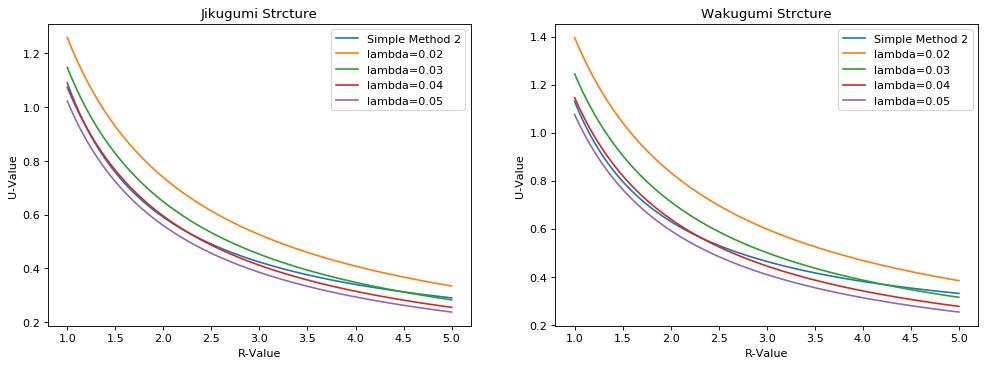

In [144]:
# fig = plt.figure(figsize=(15,5),dpi=80)
plt.figure(figsize=(15,5),dpi=80)

R = np.linspace(1,5,100)

plt.subplot(121)
plt.xlabel('R-Value')
plt.ylabel('U-Value')
plt.title('Jikugumi Strcture')
plt.plot( R, 1/R+0.09, label = 'Simple Method 2')
for l in [ 0.02, 0.03, 0.04, 0.05 ]:
    plt.plot( R, U_wall_simple( True, 'Jik', l, l*R, 0, 0 ), label = 'lambda='+str(l) )
plt.legend()

plt.subplot(122)
plt.title('Wakugumi Strcture')
plt.xlabel('R-Value')
plt.ylabel('U-Value')
plt.plot( R, 1/R+0.13, label = 'Simple Method 2')
for l in [ 0.02, 0.03, 0.04, 0.05 ]:
    plt.plot( R, U_wall_simple( True, 'Waku', l, l*R, 0, 0 ), label = 'lambda='+str(l) )
plt.legend()

plt.show()